In [1]:
import tensorflow as tf

In [2]:
# RELU

In [3]:
x = tf.Variable(tf.range(-8.0,8.0,0.1),dtype=tf.float32)
y = tf.nn.relu(x)

2021-10-27 06:08:28.667731: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-27 06:08:28.712598: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.785GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-10-27 06:08:28.714059: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:65:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.785GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-10-27 06:08:28.718377: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-10-27 06:08:28.746563: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
202

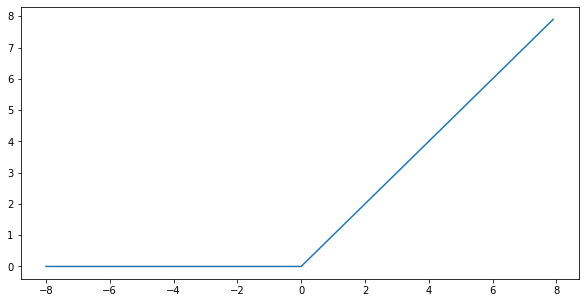

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(x.numpy(),y.numpy())

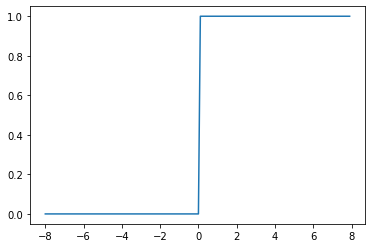

In [5]:
with tf.GradientTape() as t :
    y = tf.nn.relu(x)
plt.plot(x.numpy(),t.gradient(y,x).numpy())

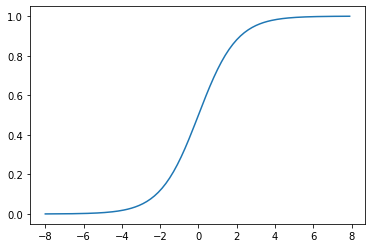

In [6]:
y = tf.nn.sigmoid(x)
plt.plot(x.numpy(),y.numpy())

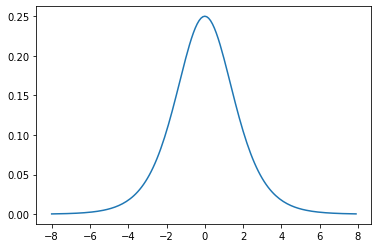

In [7]:
with tf.GradientTape() as t:
    y = tf.nn.sigmoid(x)
plt.plot(x.numpy(),t.gradient(y,x).numpy())

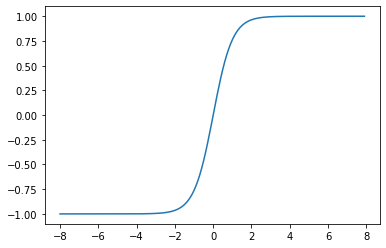

In [8]:
y = tf.nn.tanh(x)
plt.plot(x.numpy(),y.numpy())

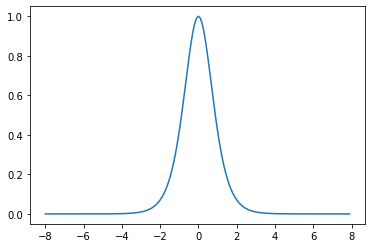

In [9]:
with tf.GradientTape() as t:
    y = tf.nn.tanh(x)
plt.plot(x.numpy(),t.gradient(y,x).numpy())

In [10]:
#4.2

In [11]:
import tensorflow as tf
import numpy as np

In [12]:
def load_data_fashion_mnist(batch_size, resize=None):   #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中。"""
    mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()
    # 将所有数字除以255，使所有像素值介于0和1之间，在最后添加一个批处理维度，
    # 并将标签转换为int32。
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,
                            tf.cast(y, dtype='int32'))
    resize_fn = lambda X, y: (
        tf.image.resize_with_pad(X, resize, resize) if resize else X, y)
    return (
        tf.data.Dataset.from_tensor_slices(process(*mnist_train)).batch(
            batch_size).shuffle(len(mnist_train[0])).map(resize_fn),
        tf.data.Dataset.from_tensor_slices(process(*mnist_test)).batch(
            batch_size).map(resize_fn))

In [13]:
batch_size = 256
train_iter ,test_iter = load_data_fashion_mnist(batch_size)

In [14]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = tf.Variable(tf.random.normal(
    shape=(num_inputs, num_hiddens), mean=0, stddev=0.01))
b1 = tf.Variable(tf.zeros(num_hiddens))
W2 = tf.Variable(tf.random.normal(
    shape=(num_hiddens, num_outputs), mean=0, stddev=0.01))
b2 = tf.Variable(tf.random.normal([num_outputs], stddev=.01))

params = [W1, b1, W2, b2]

In [15]:
def relu(X):
    return tf.math.maximum(X,0)

In [16]:
def net(X):
    X = tf.reshape(X,(-1,num_inputs))
    H = relu(tf.matmul(X,W1)+b1)
    return tf.matmul(H,W2)+b2

In [17]:
def loss(y_hat,y):
    return tf.losses.sparse_categorical_crossentropy(y,y_hat,from_logits=True)
    

In [71]:
class Updater():  #@save
    """用小批量随机梯度下降法更新参数。"""
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def __call__(self, batch_size, grads):
        sgd(self.params, grads, self.lr, batch_size)

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）。"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
        print('test_acc:',test_acc)
    train_loss, train_acc = train_metrics
    print('train_loss:',train_loss, '\ntrain_acc:', train_acc)
    #assert train_loss < 0.5, train_loss
    #assert train_acc <= 1 and train_acc > 0.7, train_acc
    #assert test_acc <= 1 and test_acc > 0.7, test_acc

from IPython import display

def use_svg_display():
    """使用svg格式在Jupyter中显示绘图。
    Defined in :numref:`sec_calculus`"""
    display.set_matplotlib_formats('svg')
use_svg_display()

class Animator:  #@save
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
    
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）。"""
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        with tf.GradientTape() as tape:
            y_hat = net(X)
            # Keras内置的损失接受的是（标签，预测），这不同于用户在本书中的实现。
            # 本书的实现接受（预测，标签），例如我们上面实现的“交叉熵”
            if isinstance(loss, tf.keras.losses.Loss):
                l = loss(y, y_hat)
            else:
                l = loss(y_hat, y)
        if isinstance(updater, tf.keras.optimizers.Optimizer):
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            updater.apply_gradients(zip(grads, params))
        else:
            updater(X.shape[0], tape.gradient(l, updater.params))
        # Keras的`loss`默认返回一个批量的平均损失
        l_sum = l * float(tf.size(y)) if isinstance(
            loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l_sum, accuracy(y_hat, y), tf.size(y))
    # 返回训练损失和训练准确率
    return metric[0] / metric[2], metric[1] / metric[2]

class Accumulator:  #@save
    """在`n`个变量上累加。"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def sgd(params,grads,lr,batch_size):
    for param,grad in zip(params,grads):
        param.assign_sub(lr*grad/batch_size)
        
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量。"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = tf.argmax(y_hat, axis=1)
    cmp = tf.cast(y_hat, y.dtype) == y
    return float(tf.reduce_sum(tf.cast(cmp, y.dtype)))

size = lambda a: tf.size(a).numpy()

def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度。"""
    metric = Accumulator(2)  # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴。
    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个TensorFlow数据迭代器。
    Defined in :numref:`sec_linear_concise`"""
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
    if is_train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    return dataset

/home/diandian/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


test_acc: 0.8326
train_loss: 0.4472581970214844 
train_acc: 0.8454833333333334


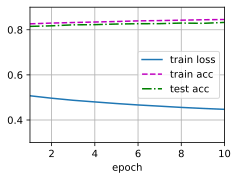

In [21]:
num_epochs,lr=10,0.02
updater = Updater([W1,W2,b1,b2],lr)
train_ch3(net,train_iter,test_iter,loss,num_epochs,updater)

In [22]:
def predict_ch3(net, test_iter, n=6):
    """预测标签（定义见第3章）。
    Defined in :numref:`sec_softmax_scratch`"""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(tf.argmax(net(X), axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        tf.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])

def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签。"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    print(figsize)
    _,axes = plt.subplots(num_rows,num_cols,figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

(9.0, 1.5)


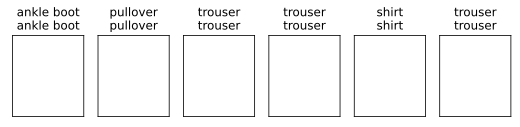

In [23]:
predict_ch3(net, test_iter)

In [24]:
# 4.3

In [27]:
net = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation = 'relu'),
    tf.keras.layers.Dense(10)
])

test_acc: 0.8676
train_loss: 0.2735976589838664 
train_acc: 0.899


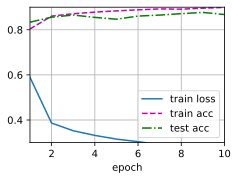

In [34]:
batch_size,lr ,num_epochs = 256,0.01,10
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
trainer = tf.keras.optimizers.Adam(learning_rate=lr)

train_iter,test_iter = load_data_fashion_mnist(batch_size)
train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

In [35]:
#4.4

In [36]:
import math
import numpy as np
import tensorflow as tf

In [67]:
max_drgree = 20 #最大阶数
n_train,n_test = 100,100 # 训练和测试数据集大小
true_w = np.zeros(max_drgree) # 先分配空间
true_w[0:4] = np.array([5,1.5,-2,7.2])

features = np.random.normal(size = (n_train + n_test,1)) # (4, 1)
np.random.shuffle(features) # 打乱

poly_features = np.power(features,np.arange(max_drgree).reshape(1,-1)) # (4, 20)
for i in range(max_drgree):
    poly_features[:,i] /= math.gamma(i+1)

labels = np.dot(poly_features,true_w)
labels += np.random.normal(scale=0.1,size=labels.shape)

In [69]:
# NumPy ndarray转换为tensor
true_w,features,poly_features,labels = [tf.constant(x,dtype=tf.float32) for x in [true_w,features,poly_features,labels]]

features[:2],poly_features[:2,:],labels[:2]

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[-1.2722915],
        [-0.5549465]], dtype=float32)>,
 <tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[ 1.00000000e+00, -1.27229154e+00,  8.09362948e-01,
         -3.43248576e-01,  1.09178066e-01, -2.77812667e-02,
          5.89097897e-03, -1.07072038e-03,  1.70283573e-04,
         -2.40722620e-05,  3.06269362e-06, -3.54239944e-07,
          3.75580420e-08, -3.67575259e-09,  3.34044931e-10,
         -2.83335039e-11,  2.25303001e-12, -1.68618293e-13,
          1.19184244e-14, -7.98090113e-16],
        [ 1.00000000e+00, -5.54946482e-01,  1.53982788e-01,
         -2.84840688e-02,  3.95178329e-03, -4.38605639e-04,
          4.05671090e-05, -3.21608172e-06,  2.23094162e-07,
         -1.37561456e-08,  7.63392460e-10, -3.85129047e-11,
          1.78105003e-12, -7.60297993e-14,  3.01374767e-15,
         -1.11497911e-16,  3.86721081e-18, -1.26240880e-19,
          3.89205159e-21, -1.13677911e-22]], dtype=float32)>,
 <tf.Tensor: 

In [70]:
def evaluate_loss(net,data_iter,loss):
    metric = Accumulator(2)
    for X,y in data_iter:
        l = loss(net(X),y)
        metric.add(tf.reduce_sum(l),size(l))
    return metric[0]/metric[1]

In [72]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = tf.losses.MeanSquaredError()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1, use_bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = load_array((train_features, train_labels), batch_size)
    test_iter = load_array((test_features, test_labels), batch_size, is_train=False)
    trainer = tf.keras.optimizers.SGD(learning_rate=.01)
    animator = Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs], ylim=[1e-3, 1e2], legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net.get_weights()[0].T)

weight: [[ 4.9873223  1.482275  -2.016437   7.2088666]]


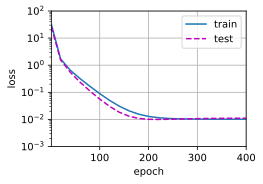

In [73]:
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

weight: [[3.9479225 5.280152 ]]


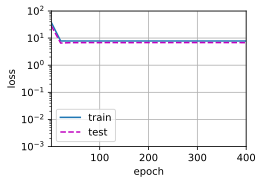

In [74]:
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

weight: [[ 4.9959168e+00  1.6279802e+00 -2.0661700e+00  6.4269457e+00
   4.2449092e-03  2.0547481e+00  4.7932383e-02  4.5959601e-01
   1.5459415e-01 -4.1639325e-01 -3.9656287e-01  4.6325222e-01
   4.3631142e-01  2.2957833e-01  3.7005144e-01 -2.1244240e-01
  -2.6167935e-01 -2.9151079e-01 -7.9683959e-02  1.7590034e-01]]


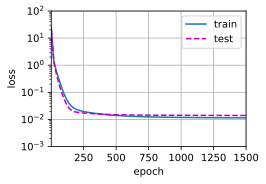

In [75]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1500)

In [76]:
# 4.5

In [77]:
import tensorflow

In [79]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声。
    Defined in :numref:`sec_linear_scratch`"""
    X = tf.zeros((num_examples, w.shape[0]))
    X += tf.random.normal(shape=X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1, 1))
    return X, y

In [80]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = tf.ones((num_inputs, 1)) * 0.01, 0.05
train_data = synthetic_data(true_w, true_b, n_train)
train_iter = load_array(train_data, batch_size)
test_data = synthetic_data(true_w, true_b, n_test)
test_iter = load_array(test_data, batch_size, is_train=False)

In [81]:
def init_params():
    w = tf.Variable(tf.random.normal(mean=1, shape=(num_inputs, 1)))
    b = tf.Variable(tf.zeros(shape=(1, )))
    return [w, b]

In [82]:
def l2_penalty(w):
    return tf.reduce_sum(tf.pow(w, 2)) / 2

In [87]:
def linreg(X, w, b):
    """线性回归模型。
    Defined in :numref:`sec_linear_scratch`"""
    return tf.matmul(X, w) + b

def squared_loss(y_hat, y):
    """均方损失。
    Defined in :numref:`sec_linear_scratch`"""
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 / 2

In [88]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: linreg(X, w, b), squared_loss
    num_epochs, lr = 100, 0.003
    animator = Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                # 增加了L2范数惩罚项，广播机制使l2_penalty(w)成为一个长度为`batch_size`的向量。
                l = loss(net(X), y) + lambd * l2_penalty(w)
            grads = tape.gradient(l, [w, b])
            sgd([w, b], grads, lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', tf.norm(w).numpy())

w的L2范数是： 18.756739


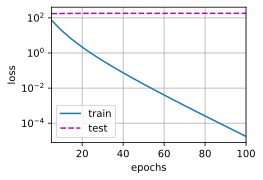

In [89]:
train(lambd=0)

w的L2范数是： 0.50690305


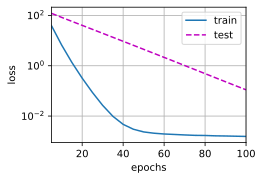

In [90]:
train(lambd=3)

In [91]:
#4.5.4

In [92]:
def train_concise(wd):
    net = tf.keras.models.Sequential()
    net.add(tf.keras.layers.Dense(
        1, kernel_regularizer=tf.keras.regularizers.l2(wd)))
    net.build(input_shape=(1, num_inputs))
    w, b = net.trainable_variables
    loss = tf.keras.losses.MeanSquaredError()
    num_epochs, lr = 100, 0.003
    trainer = tf.keras.optimizers.SGD(learning_rate=lr)
    animator = Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                # `tf.keras` 需要为自定义训练代码手动添加损失。
                l = loss(net(X), y) + net.losses
            grads = tape.gradient(l, net.trainable_variables)
            trainer.apply_gradients(zip(grads, net.trainable_variables))
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', tf.norm(net.get_weights()[0]).numpy())

w的L2范数： 1.2375121


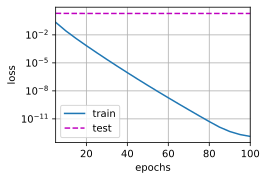

In [93]:
train_concise(0)

w的L2范数： 0.041727684


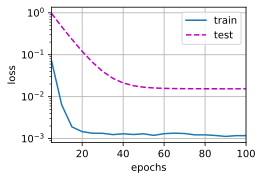

In [94]:
train_concise(3)

In [95]:
#4.6

In [96]:
import tensorflow as tf

In [99]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃。
    if dropout == 1:
        return tf.zeros_like(X)
    # 在本情况中，所有元素都被保留。
    if dropout == 0:
        return X
    mask = tf.random.uniform(shape=tf.shape(X), minval=0, maxval=1) < 1 - dropout
    return tf.cast(mask, dtype=tf.float32) * X / (1.0 - dropout)

In [106]:
X = tf.reshape(tf.range(16, dtype=tf.float32), (2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tf.Tensor(
[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]], shape=(2, 8), dtype=float32)
tf.Tensor(
[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]], shape=(2, 8), dtype=float32)
tf.Tensor(
[[ 0.  0.  4.  6.  8.  0.  0. 14.]
 [16. 18. 20.  0.  0. 26. 28. 30.]], shape=(2, 8), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]], shape=(2, 8), dtype=float32)


In [107]:
num_outputs, num_hiddens1, num_hiddens2 = 10, 256, 256

In [108]:
dropout1, dropout2 = 0.2, 0.5

class Net(tf.keras.Model):
    def __init__(self, num_outputs, num_hiddens1, num_hiddens2):
        super().__init__()
        self.input_layer = tf.keras.layers.Flatten()
        self.hidden1 = tf.keras.layers.Dense(num_hiddens1, activation='relu')
        self.hidden2 = tf.keras.layers.Dense(num_hiddens2, activation='relu')
        self.output_layer = tf.keras.layers.Dense(num_outputs)

    def call(self, inputs, training=None):
        x = self.input_layer(inputs)
        x = self.hidden1(x)
        # 只有在训练模型时才使用dropout
        if training:
            # 在第一个全连接层之后添加一个dropout层
            x = dropout_layer(x, dropout1)
        x = self.hidden2(x)
        if training:
            # 在第二个全连接层之后添加一个dropout层
            x = dropout_layer(x, dropout2)
        x = self.output_layer(x)
        return x

net = Net(num_outputs, num_hiddens1, num_hiddens2)

test_acc: 0.8716
train_loss: 0.2824054164886475 
train_acc: 0.8928666666666667


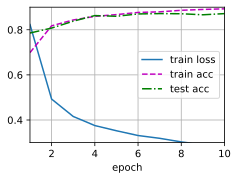

In [109]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_iter, test_iter = load_data_fashion_mnist(batch_size)
trainer = tf.keras.optimizers.SGD(learning_rate=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [110]:
net = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    # 在第一个全连接层之后添加一个dropout层
    tf.keras.layers.Dropout(dropout1),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    # 在第二个全连接层之后添加一个dropout层
    tf.keras.layers.Dropout(dropout2),
    tf.keras.layers.Dense(10),
])

test_acc: 0.8534
train_loss: 0.3026447734196981 
train_acc: 0.8863166666666666


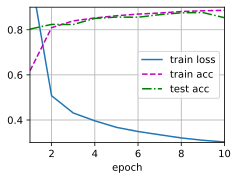

In [111]:
trainer = tf.keras.optimizers.SGD(learning_rate=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [112]:
#4.8

In [113]:
M = tf.random.normal((4, 4))
print('一个矩阵 \n', M)
for i in range(100):
    M = tf.matmul(M, tf.random.normal((4, 4)))

print('乘以100个矩阵后\n', M.numpy())

一个矩阵 
 tf.Tensor(
[[ 0.11968056  0.24362281  0.47667405  0.85640085]
 [-0.1969492  -0.05066199 -1.9497331  -0.15723188]
 [ 0.9389188   0.02572126  0.08135172 -0.70518965]
 [ 0.65679747 -0.54866296  0.6078781  -0.85455245]], shape=(4, 4), dtype=float32)
乘以100个矩阵后
 [[-2.7467110e+25 -1.7822089e+25 -1.8214711e+25  3.6942418e+24]
 [ 2.6460365e+25  1.7168859e+25  1.7547092e+25 -3.5588390e+24]
 [ 4.0121004e+25  2.6032592e+25  2.6606087e+25 -5.3961563e+24]
 [ 4.7170423e+25  3.0606621e+25  3.1280886e+25 -6.3442780e+24]]


In [114]:
#4.10

In [115]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [116]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名。"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [117]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件。"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩。'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件。"""
    for name in DATA_HUB:
        download(name)

In [145]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [119]:
DATA_HUB['kaggle_house_train'] = (DATA_URL + 'kaggle_house_pred_train.csv', '585e9cc93e70b39160e7921475f9bcd7d31219ce')
DATA_HUB['kaggle_house_test'] = (DATA_URL + 'kaggle_house_pred_test.csv', 'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [120]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载../data/kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载../data/kaggle_house_pred_test.csv...


In [121]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [122]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [123]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [124]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有数据都意味着消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [125]:
# `Dummy_na=True` 将“na”（缺失值）视为有效的特征值，并为其创建指示符特征。
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [126]:
n_train = train_data.shape[0]
train_features = tf.constant(all_features[:n_train].values, dtype=tf.float32)
test_features = tf.constant(all_features[n_train:].values, dtype=tf.float32)
train_labels = tf.constant(
    train_data.SalePrice.values.reshape(-1, 1), dtype=tf.float32)

In [127]:
loss = tf.keras.losses.MeanSquaredError()

def get_net():
    net = tf.keras.models.Sequential()
    net.add(tf.keras.layers.Dense(
        1, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    return net

In [128]:
def log_rmse(y_true, y_pred):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = tf.clip_by_value(y_pred, 1, float('inf'))
    return tf.sqrt(tf.reduce_mean(loss(
        tf.math.log(y_true), tf.math.log(clipped_preds))))

In [129]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    net.compile(loss=loss, optimizer=optimizer)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                y_hat = net(X)
                l = loss(y, y_hat)
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            optimizer.apply_gradients(zip(grads, params))
        train_ls.append(log_rmse(train_labels, net(train_features)))
        if test_labels is not None:
            test_ls.append(log_rmse(test_labels, net(test_features)))
    return train_ls, test_ls

In [130]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = tf.concat([X_train, X_part], 0)
            y_train = tf.concat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [158]:
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点。
    Defined in :numref:`sec_calculus`"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # 如果 `X` 有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    

def set_figsize(figsize=(3.5, 2.5)):
    """设置matplotlib的图表大小。
    Defined in :numref:`sec_calculus`"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

In [159]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

/home/diandian/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


fold 1, train log rmse 0.170287, valid log rmse 0.156903
fold 2, train log rmse 0.162466, valid log rmse 0.190814
fold 3, train log rmse 0.163861, valid log rmse 0.168397
fold 4, train log rmse 0.168216, valid log rmse 0.154818
fold 5, train log rmse 0.163123, valid log rmse 0.183133
5-折验证: 平均训练log rmse: 0.165591, 平均验证log rmse: 0.170813


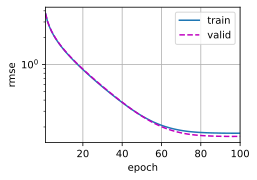

In [160]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, 'f'平均验证log rmse: {float(valid_l):f}')

In [163]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 0.162498


/home/diandian/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


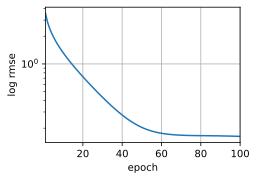

In [164]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)